# Лабораторная работа №2
Выполнил студент группы 9381 Матвеев Андрей

### Цель работы
Практическое применение дискретного преобразования Фурье c
использованием библиотек Python для анализа речевых сигналов.

### Задачи лабораторной работы

1. Используя ДПФ построить траекторию основного тона (F0) на записи своего голоса.
2. Используя ДПФ построить траектории второй, третьей и четвертой формантных частот на
записи своего голоса
3. Построить сонограмму по записи своего голоса.

### Выполнение работы

##### 0. Запись голоса.

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import scipy.io.wavfile as sciowav
import IPython.display as ipd
import more_itertools
import plotly.express as px
%matplotlib inline

def draw(x, y, title = '', xLabel = '', yLabel = '',sizes = (16,10)): # отрисовка графиков
    plt.figure(figsize=sizes, dpi=100)
    plt.plot(x, y)
    plt.title(title)
    plt.grid(True)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.show()
    
    

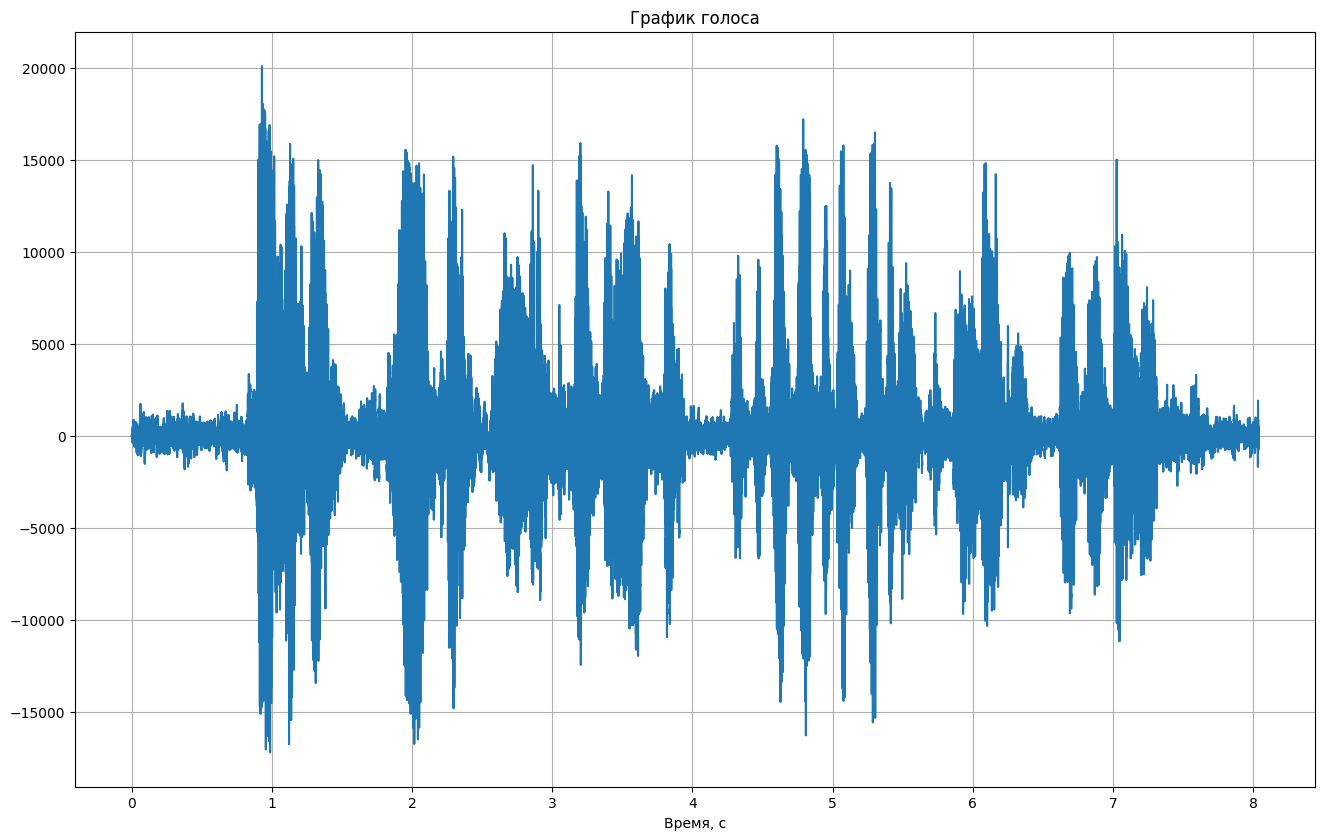

In [109]:
spf = wave.open("myVoice.wav", "rb") 
countFrames = spf.readframes(-1) 
signal = np.frombuffer(countFrames, np.int16) 
fs = spf.getframerate() # возвращает частоту дискретизации

if spf.getnchannels() == 2:
    print("Just mono files")
    sys.exit(0)

time = np.linspace(0, len(signal) / fs, num=len(signal)) 

draw(time, signal, "График голоса", xLabel = "Время, c", yLabel = '')
ipd.Audio('myVoice.wav')

#####  1. Используя ДПФ построить траекторию основного тона (F0) на записи своего голоса.

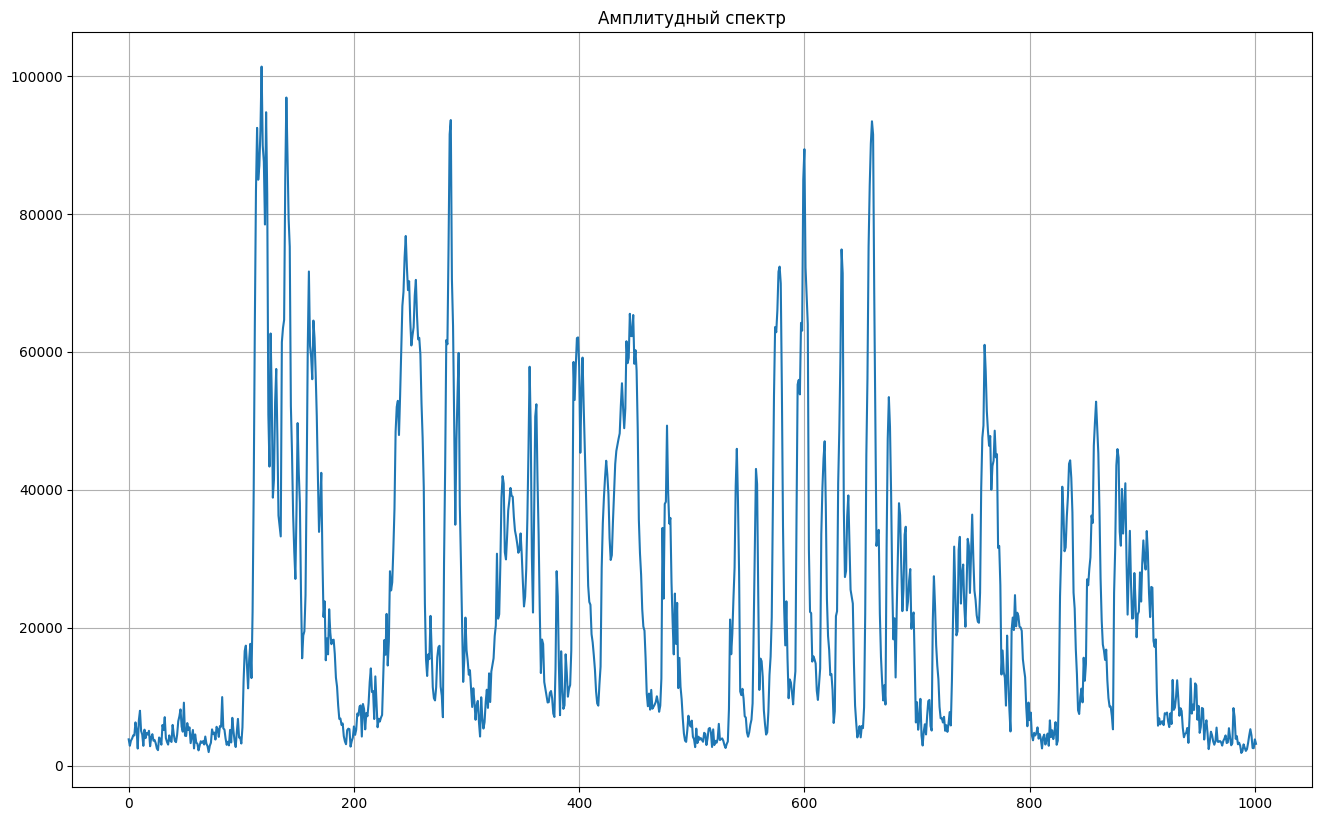

In [110]:
N = 512 # длина кадра
Sr = round(fs/N)

intervals = list(more_itertools.windowed(signal, n=N, step=int(0.25*N))) # Разбиваем сигнал на отрезки длиной N c шагом 0.25*N
lInt = len(intervals)
intervals[lInt - 1] = [i for i in intervals[lInt - 1] if i is not None] 
intervals = [i*np.hamming(len(i)) for i in intervals] # На каждом отрезке сигнал предварительно умножаем на окно Хемминга
from scipy.fft import rfft
intervalsAfterDPF = [rfft(j) for j in intervals] # используем быстрый алгоритм для ДПФ

'''
def DFT_slow(x):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)
    # Альтернативный алгоритм ДПФ (позаимствован с ресурса habr). Очень медленный и неэффективный, производил вычисления несколько минут, в то время как встроенный быстрый делает то же
    # самое за секунду. !!! Быстрый не является частью librosa или openSMILE
'''

specter = []
for i in intervals:
    specter.append(sum([j**2 for j in i[:int(len(i)/2)]])**0.5)
    
specter = np.array([i.real for i in specter])

draw(np.arange(len(specter)), specter, "Амплитудный спектр", sizes=(16,10))


##### Траектория основного тона F0

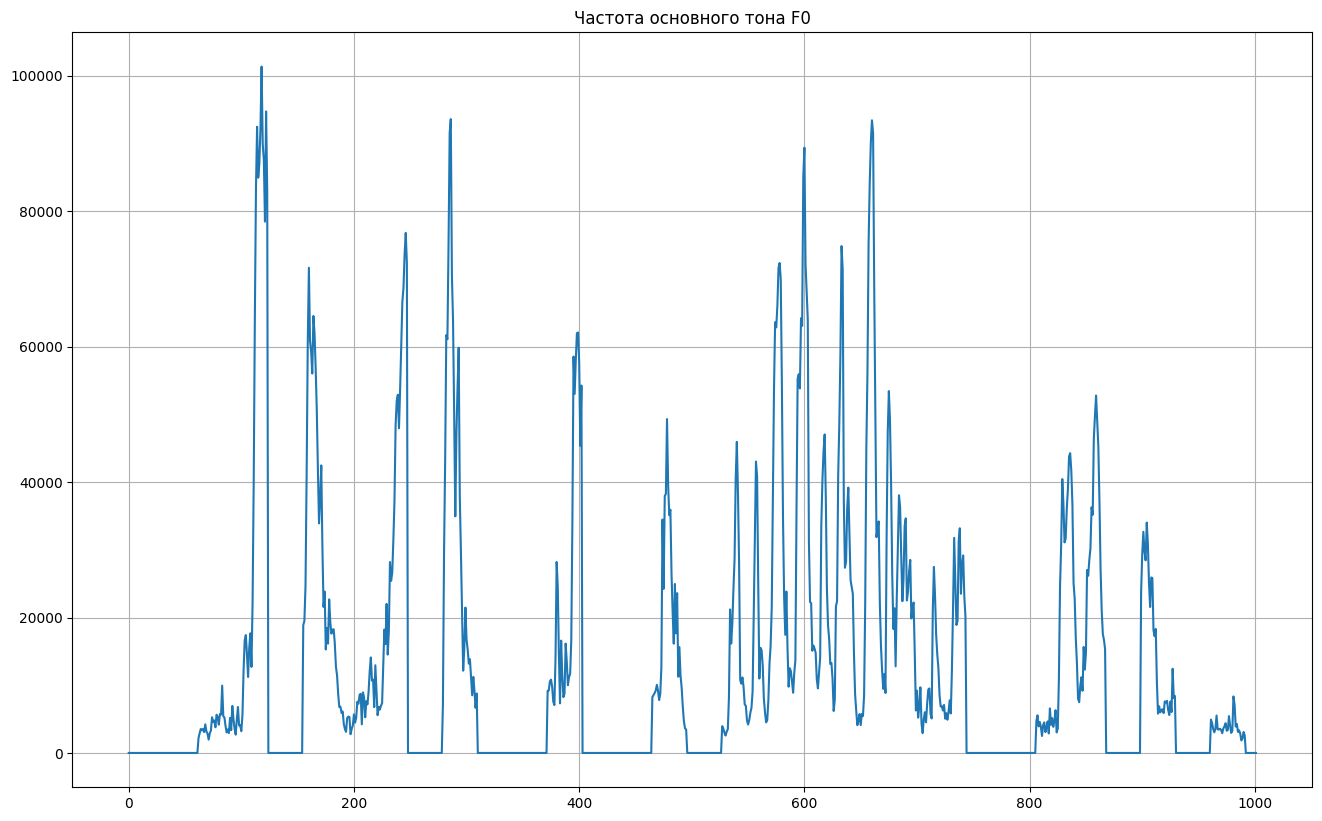

In [111]:
F0 = []
sLen = len(specter)
for i in range(0, sLen, Sr):
    section = np.array(specter[i:i+Sr])               
    if section.max() > 2*section.mean():            
        F0 += list(section)
    else:
        F0 += [0 for i in range(len(section))]
        
draw(np.arange(len(F0)), F0, "Частота основного тона F0", sizes=(16,10))

##### 2. Используя ДПФ построить траектории второй, третьей и четвертой формантных частот на записи своего голоса

Для F1. Берём $2n_0$ и в её окрестности (не в самой точке) ищем второй максимум.

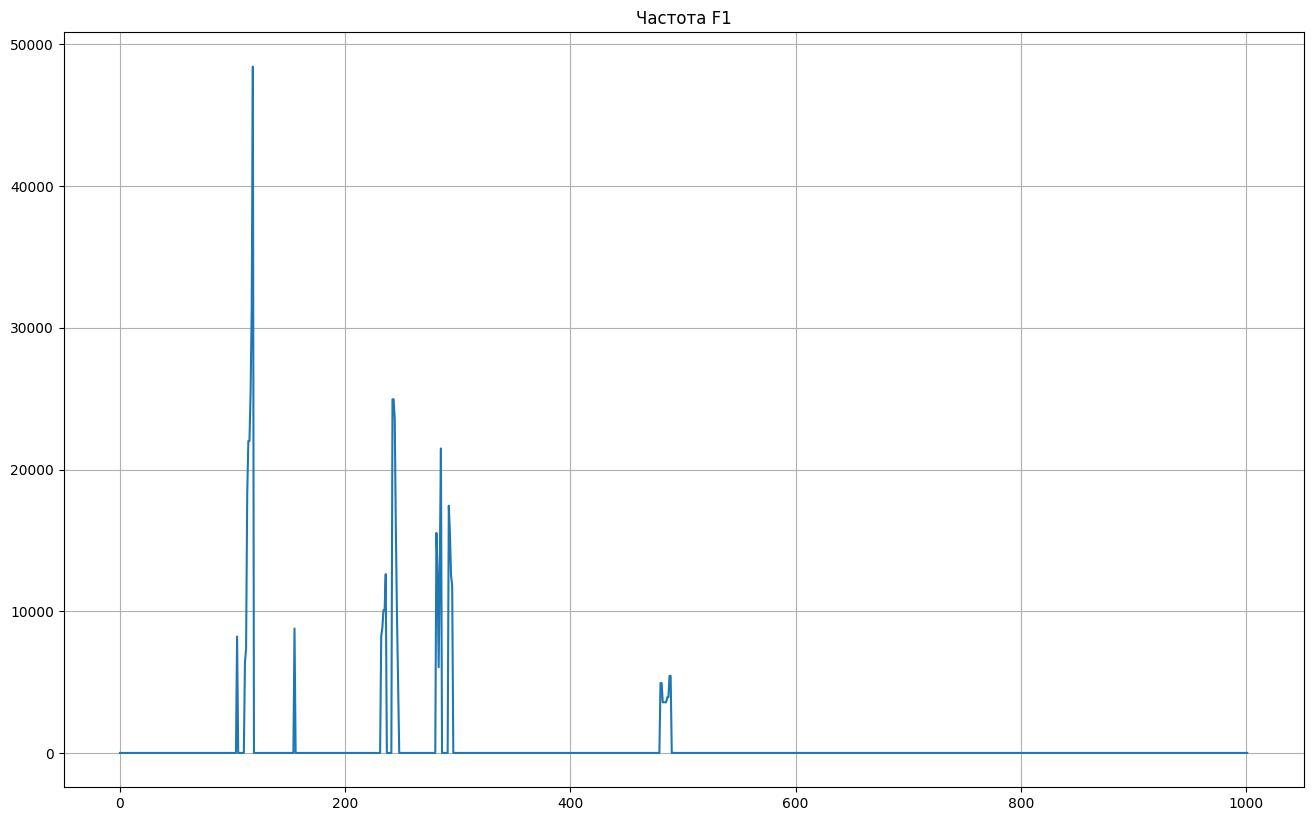

In [112]:
F1 = []
it = 0
lenF0 = len(F0)
while it < lenF0:
    if ((2*it-1)  in range(lenF0)) and ((2*it+1)  in range(lenF0)) :
        secondMax = max(F0[2*it-1], F0[2*it+1])
        if F0[it] > 2*secondMax:           
            F1.append(secondMax)
        else:
            F1.append(0)
    else:
        F1.append(0)
    it += 1
    
draw(np.arange(len(F0)), F1, "Частота F1", sizes=(16,10))

Для F2.

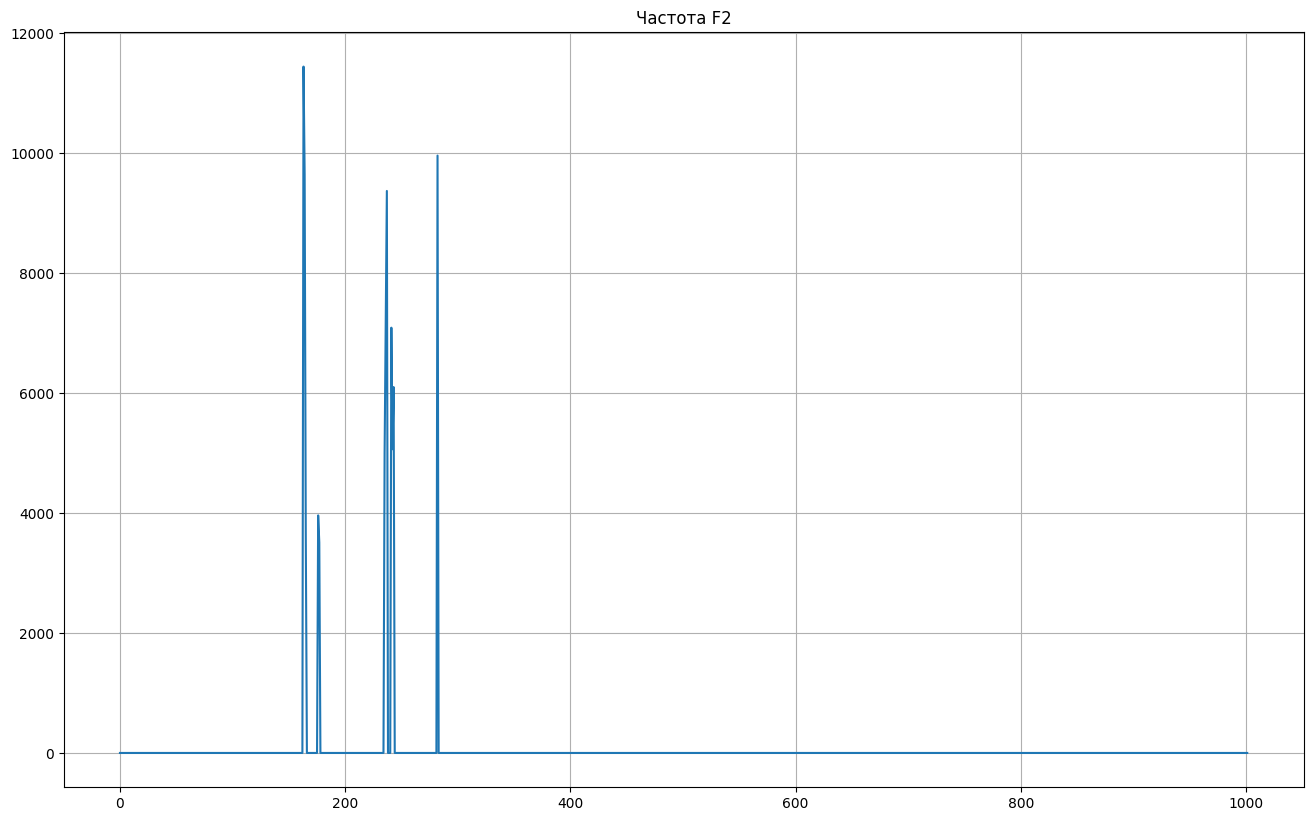

In [113]:
F2 = []
it = 0

while it < lenF0:
    if ((3*it-1)  in range(lenF0)) and ((3*it+1)  in range(lenF0)) :
        thirdMax = max(F0[3*it-1], F0[3*it+1])
        if F0[it] > 4*thirdMax:           
            F2.append(thirdMax)
        else:
            F2.append(0)
    else:
        F2.append(0)
    it += 1
    
draw(np.arange(len(F0)), F2, "Частота F2", sizes=(16,10))

Для F3.

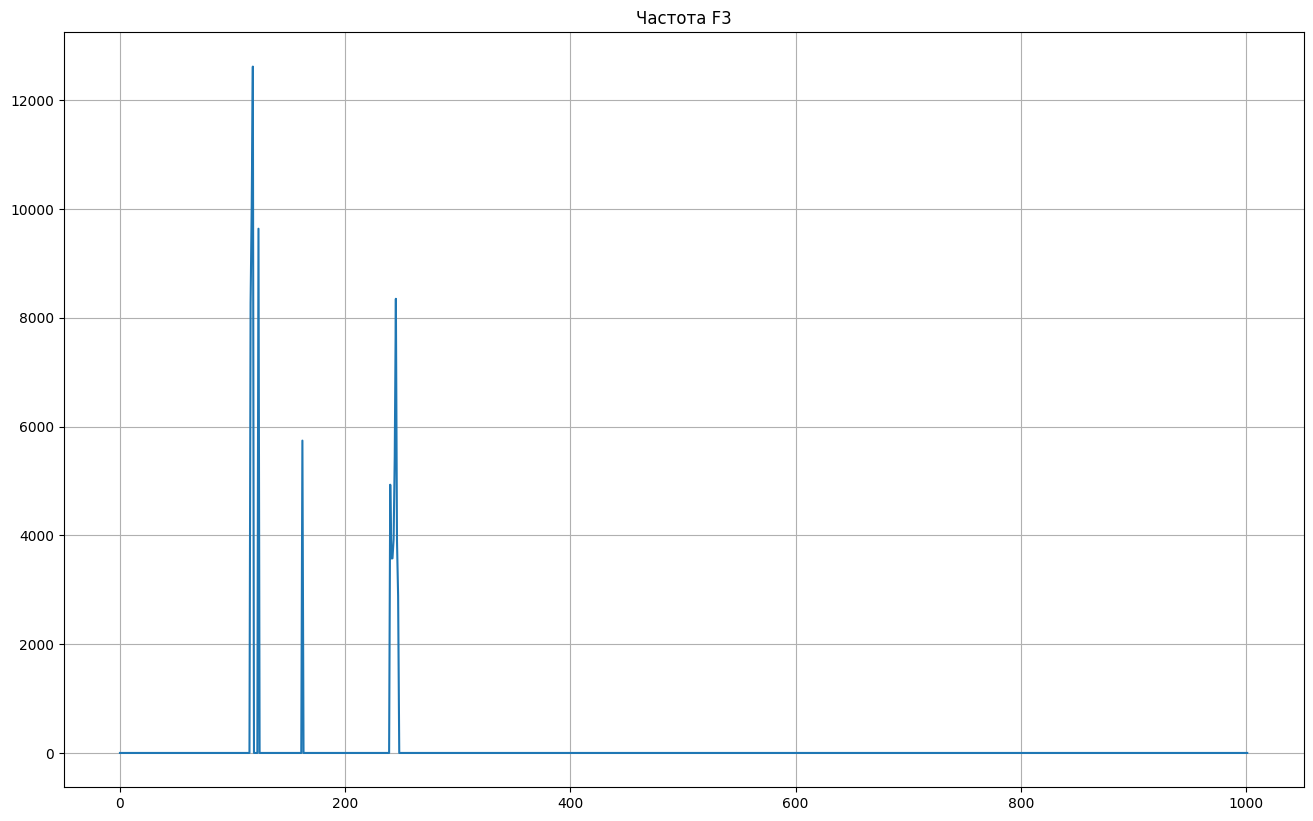

In [114]:
F3 = []
it = 0

while it < lenF0:
    if ((4*it-1)  in range(lenF0)) and ((4*it+1)  in range(lenF0)) :
        fourthMax = max(F0[4*it-1], F0[4*it+1])
        if F0[it] > 8*fourthMax:           
            F3.append(fourthMax)
        else:
            F3.append(0)
    else:
        F3.append(0)
    it += 1
    
draw(np.arange(len(F0)), F3, "Частота F3", sizes=(16,10))

##### 3. Построить сонограмму по записи своего голоса.

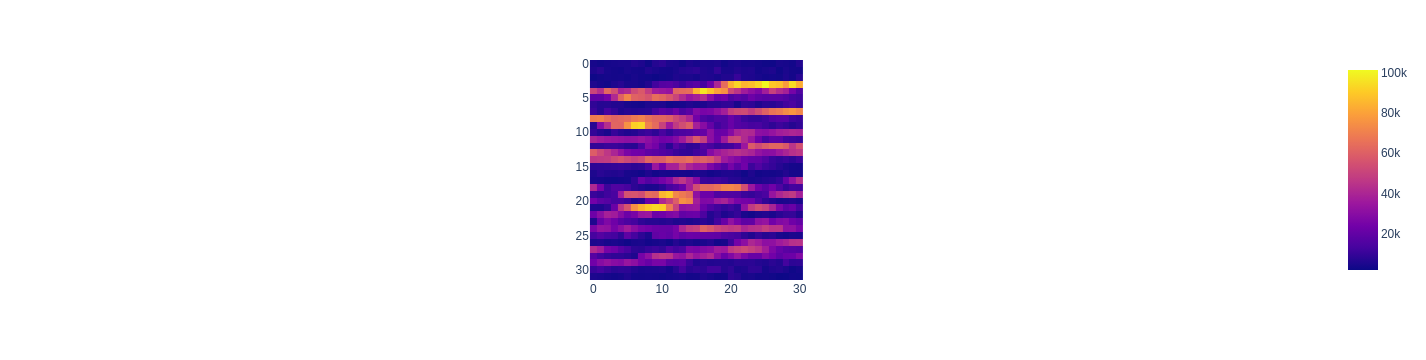

In [115]:
sLen = len(specter)
sonogram = []

for i in range(0, sLen, Sr):
    section = list(specter[i:i+Sr])  
    sonogram.append(section)


sonogram = sonogram[:-1] #обрезаем неоднородный элемент
sonogram = np.array(sonogram)
sonogram.reshape(len(sonogram), len(sonogram[0])) # формируем матрицу сонограммы


fig = px.imshow(sonogram) # строим сонограмму
fig.show()

##### png-формат сонограммы:

![](./newplot.png)


### Вывод:
1. Построена траектория основного тона (F0) на записи своего голоса.
2. Построены траектории второй, третьей и четвертой формантных частот на
записи своего голоса
3. Построена сонограмма по записи своего голоса.